#Example of extracting features from a pretrained neural network in Caffe using SkiCaffe

SkiCaffe is a wrapper that provides a "scikit-learn like" API to pretrained networks such as those distributed in the [Caffe Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) or elsewhere (such as [DeepDetect](http://www.deepdetect.com/applications/model/)). Basically, I wanted to use these pretrained models for extracting features, but also use the powerful pipelines of scikit-learn. Here we illustrate it's basic use for extracting features. 

In [1]:
from skicaffe import SkiCaffe

To use SKiCaffe, we need Caffe so we have to specify where Caffe was installed. We assume that the installation of Caffe is the default one from [BVLC](https://github.com/BVLC/caffe). We specify the location of Caffe on our system with caffe_root:

In [2]:
caffe_root = '/usr/local/src/caffe/caffe-master/'
DLmodel = SkiCaffe('/usr/local/src/caffe/caffe-master/')

caffe imported successfully


In Scikit-learn parlance, SkiCaffe is an estimator, since it is meant for extracting features from images. Therefore SkiCaffe inherits from the [BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html#sklearn.base.BaseEstimator) and [TransformerMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html#sklearn.base.TransformerMixin) classes. The two methods that we overwrite are the fit and transform methods. SkiCaffe is a bit unusual in that the input data that is transformed is not a numpy array X of shape [n_samples, n_features], but rather the input is a python list of image paths. SkiCaffe takes these image paths and "transforms" them by returning features that are derived from a pretrained neural net in Caffe. 

The fit method loads the specified pretrained network. The transform method takes the list of images paths and returns the image features extracted from a specific layer as a numpy array (or optionally a Pandas Data Frame).  

To load the pretrained network, the fit method in SkiCaffe needs the paths for the following two files:
- deploy.prototxt file: neural network definition file for prediction
- caffemodel file: the trained neural network (for example, bvlc_googlenet.caffemodel)

The current setup of SkiCaffe is very ImageNet centric, therefore other supporting files from the default installation of Caffe are used (see documentation for more details and change as needed). 





##Load pretrained BVLC reference model

In this example we will be using the BVLC reference model and specify the protxt file and trained caffemodel file.

In [3]:
model_prototxt = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_trained = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

We now "fit" the model by loading the pretrained network. We can also use the layer_sizes attribute of our model to see what the different layers and their sizes are.

In [4]:
DLmodel.fit(model_prototxt_path = model_prototxt, model_trained_path = model_trained)
print 'Number of layers:', len(DLmodel.layer_sizes)
DLmodel.layer_sizes

Number of layers: 15


[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

##Specify list of images and extract features

In [5]:
image_paths = ['./images/cat.jpg', 
               './images/1404329745.jpg']

We can now "transform" these images by extracting their features from our pretrained network. All we have to do is specify the layer name (listed above). Here we select the output of the last fully connected layer "fc8". If you like Data Frames (like me), then you can optionally specify that the return type be a Pandas Data Frame. 

In [6]:
image_features = DLmodel.transform(image_paths = image_paths, layer_name = 'fc8', return_type = 'pandasDF')
image_features.head()

,fc8.0,fc8.1,fc8.2,fc8.3,fc8.4,fc8.5,fc8.6,fc8.7,fc8.8,fc8.9,...,fc8.990,fc8.991,fc8.992,fc8.993,fc8.994,fc8.995,fc8.996,fc8.997,fc8.998,fc8.999
./images/cat.jpg,-3.951641,3.975120,-2.126729,-1.871164,-2.662033,-1.353563,-1.741234,0.325429,4.527949,0.673176,...,0.965158,-1.478449,-1.339078,-2.62203,-2.789895,-0.731774,-2.223181,-3.972737,3.412293,5.382015
./images/1404329745.jpg,-0.368596,-2.329631,-2.272708,-1.236161,0.337776,-1.146152,0.180242,-1.866234,-0.718521,1.888524,...,1.175359,0.087867,-0.151792,-2.18759,-1.585881,1.581704,-1.362859,-0.552606,5.315578,-0.433723


##Visualize features

SkiCaffe also comes with some visualization methods to gain some insight into what the features from the pretrained network are extracting. So far we are simply using the visualization methods that BVLC have provided, so this is really just a convinience function and a quick check that the feature extraction is working. 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Lets visualize what the features from one of our images look like from the first convultional layer (lablled as 'conv1'). Here we specify that we only want to visualize the first 36 filters to compare our results with BVLC. If num_filters is left unspecified, then all features are extracted. 

(96, 55, 55)


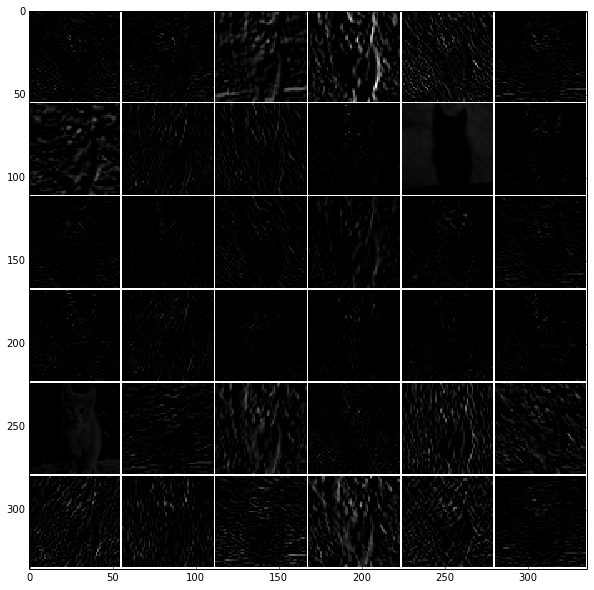

In [8]:
DLmodel.vis_img_feature(layer_name = 'conv1', image_path = image_paths[0], num_filters = 36)

Compare this with the visualization in the [BVLC Caffe classification tutorial](https://github.com/BVLC/caffe/blob/master/examples/00-classification.ipynb) in cell 29. 